In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Vertex AI Matching Engine for Text-to-Image Embeddings

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/matching_engine/sdk_matching_engine_create_text_to_image_embeddings.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/matching_engine/sdk_matching_engine_create_text_to_image_embeddings.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
      <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/matching_engine/sdk_matching_engine_create_text_to_image_embeddings.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

This example demonstrates how to create text-to-image embeddings using the DiffusionDB dataset and the CLIP model. These are uploaded to the Vertex AI Matching Engine service. It is a high scale, low latency solution to find similar vectors for a large corpus. Moreover, it is a fully managed offering, further reducing operational overhead. It is built upon [Approximate Nearest Neighbor (ANN) technology](https://ai.googleblog.com/2020/07/announcing-scann-efficient-vector.html) developed by Google Research.

**Pre-requisite**: This notebook requires you to already have a VPC network set up. See the "Prepare a VPC network" section in [Create Vertex AI Matching Engine index notebook](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/matching_engine/sdk_matching_engine_for_indexing.ipynb).

Learn more about [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview).

### Objective

In this notebook, you learn how to encode custom text embeddings, create an  Approximate Nearest Neighbor (ANN) index, and query against indexes.

This tutorial uses the following Google Cloud ML services:

- `Vertex AI Matching Engine`

The steps performed include:

* Create ANN index
* Create an index endpoint with VPC Network
* Deploy ANN index
* Perform online query


### Dataset

The dataset used for this tutorial is the [DiffusionDB dataset](https://github.com/poloclub/diffusiondb).

> DiffusionDB is the first large-scale text-to-image prompt dataset. It contains 14 million images generated by Stable Diffusion using prompts and hyperparameters specified by real users. The unprecedented scale and diversity of this human-actuated dataset provide exciting research opportunities in understanding the interplay between prompts and generative models, detecting deepfakes, and designing human-AI interaction tools to help users more easily use these models.

## Installation

Install the latest version of Cloud Storage, BigQuery and the Vertex AI SDK for Python.

In [ ]:
# Install the packages
! pip3 install --upgrade google-cloud-aiplatform \
                        google-cloud-storage --upgrade

Install the latest version of transformers and torch libraries for encoding text and image embeddings

In [ ]:
# Install the packages
! pip3 install --upgrade transformers torch --upgrade

Install the latest version of google-cloud-vision for filtering for safe images

In [ ]:
# Install the packages
! pip install google-cloud-vision

Install the latest version of pyrate_limiter for limiting Google Cloud Vision API calls

In [ ]:
# Install the packages
! pip install pyrate_limiter

### Colab only: Uncomment the following cell to restart the kernel.

In [4]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Before you begin
#### Set your project ID

If you don't know your project ID, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "[YOUR-PROJECT-ID]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [6]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [7]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [8]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

* Authentication: Rerun the `gcloud auth login` command in the Vertex AI Workbench notebook terminal when you are logged out and need the credential again.

### Colab only: Uncomment the following cell to restart the kernel.

In [9]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [10]:
BUCKET_URI = "gs://your-bucket-name-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [11]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://your-bucket-name-ah1mxx7t/...


## Prepare the data

You will use [DiffusionDB dataset](https://github.com/poloclub/diffusiondb) of image prompt and image pairs.

### Clone the DiffusionDB repo

In [ ]:
! git clone https://github.com/poloclub/diffusiondb

### Install the dependencies for downloading the dataset

In [ ]:
! pip install -r diffusiondb/requirements.txt

### Download image files

In [ ]:
# Download image files from 1 to 5. Each file is 1000 images.
! python diffusiondb/scripts/download.py -i 1 -r 5

### Extract image archives

In [ ]:
# Unzip all image files
image_directory = "extracted"

! unzip -n 'images/*.zip' -d '{image_directory}'

### Load image metadata

In [16]:
import json
import os

metadatas = {}
for file_name in os.listdir(image_directory):
    if file_name.endswith(".json"):
        with open(os.path.join(image_directory, file_name)) as f:
            metadata = json.load(f)
            metadatas.update(metadata)

image_names = list(metadatas.keys())
image_paths = [os.path.join(image_directory, image_name) for image_name in image_names]

len(metadatas)

4000

Define a function to query the Cloud Vision API to detect potential explicit images

See details at [Detect explicit content](https://cloud.google.com/vision/docs/detecting-safe-search)

In [ ]:
import io
from typing import Optional

from google.cloud import vision

client = vision.ImageAnnotatorClient()

"""Detects unsafe features in the file."""


def detect_safe_search(path: str) -> Optional[bool]:
    with io.open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.safe_search_detection(image=image)

    if response.error.message:
        print(response.error.message)
        return None

    return response.safe_search_annotation

Define a function to convert safe search annotation results to a boolean value

In [ ]:
from google.cloud.vision_v1.types.image_annotator import (Likelihood,
                                                          SafeSearchAnnotation)


# Returns true if some annotations have a potential safety issues
def convert_annotation_to_safety(safe_search_annotation: SafeSearchAnnotation) -> bool:
    return all(
        [
            (safe_level == Likelihood.VERY_UNLIKELY)
            or (safe_level == Likelihood.UNLIKELY)
            for safe_level in [
                safe_search_annotation.adult,
                safe_search_annotation.medical,
                safe_search_annotation.violence,
                safe_search_annotation.racy,
            ]
        ]
    )

Google Cloud Vision has a rate limit for API requests.

Use a rate limiter to ensure the requests go under this limit.
For better performance, use a ThreadPool to make parallel requests. This is out-of-scope for this notebook.

See [Quotas and Limits](https://cloud.google.com/vision/quotas?hl=en) for details.

In [ ]:
import numpy as np
from pyrate_limiter import Duration, Limiter, RequestRate
from tqdm import tqdm

# Create a rate limiter with a limit of 1800 requests per second
limiter = Limiter(RequestRate(1800, Duration.MINUTE))

safe_search_annotations = []
for image_path in tqdm(image_paths, total=len(image_paths)):
    limiter.try_acquire()
    safe_search_annotations.append(detect_safe_search(image_path))

# Convert annotations to boolean values
is_safe_values_cloud_vision = list(
    map(convert_annotation_to_safety, safe_search_annotations)
)

# Print number of safe images found
print(
    f"Safe images = {np.array(is_safe_values_cloud_vision).sum()} out of {len(is_safe_values_cloud_vision)} images"
)

In [ ]:
# Filter images by safety
metadatas = [
    metadata
    for metadata, is_safe in zip(metadatas, is_safe_values_cloud_vision)
    if is_safe
]
image_names = [
    image_name
    for image_name, is_safe in zip(image_names, is_safe_values_cloud_vision)
    if is_safe
]
image_paths = [
    image_path
    for image_path, is_safe in zip(image_paths, is_safe_values_cloud_vision)
    if is_safe
]

#### Instantiate the text-to-image encoding model

Use the [clip-vit-base-patch32 encoder](https://huggingface.co/openai/clip-vit-base-patch32) developed by OpenAI for converting text and images to embeddings.

> The CLIP model was developed by researchers at OpenAI to learn about what contributes to robustness in computer vision tasks. The model was also developed to test the ability of models to generalize to arbitrary image classification tasks in a zero-shot manner.

In [ ]:
import torch
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast

MODEL_ID = "openai/clip-vit-base-patch32"

device = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)

tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)
processor = CLIPProcessor.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID).to(device)

#### Defining encoding functions

Define functions to be used later that will take text and images and convert them to embeddings.

See more info here: https://huggingface.co/openai/clip-vit-base-patch32#use-with-transformers

In [18]:
import copy
from typing import List

import numpy as np
from PIL import Image
from tqdm.auto import tqdm


def encode_text_to_embedding(model, tokenizer, text: List[str]) -> np.ndarray:
    inputs = tokenizer(text, return_tensors="pt")
    embeddings = model.get_text_features(**inputs)
    return embeddings.cpu().detach().numpy()


def encode_images_to_embedding(model, device, image_paths: List[str]) -> np.ndarray:
    images = [copy.deepcopy(Image.open(path)) for path in image_paths]
    image_pixel_values = processor(
        text=None, images=images, return_tensors="pt", padding=True
    )["pixel_values"].to(device)
    embeddings = model.get_image_features(pixel_values=image_pixel_values)
    return embeddings.squeeze(0).cpu().detach().numpy()


def encode_images_to_embedding_chunked(
    model, device, image_paths: List[str], batch_size: int = 16
) -> np.ndarray:
    embeddings_list = []

    # Process images in batches to prevent out-of-memory errors.
    for i in tqdm(range(0, len(image_paths), batch_size)):
        embeddings_list.append(
            encode_images_to_embedding(
                model=model, device=device, image_paths=image_paths[i : i + batch_size]
            )
        )

    return np.vstack(embeddings_list)

#### Test the encoding function

Encode a subset of data and see if the embeddings and distance metrics make sense.

According to the [CLIP research paper](https://arxiv.org/pdf/2103.00020.pdf), the similarities of embeddings are calculated using the cosine similarity.

In [ ]:
import random

# Encode 1000 images
image_paths_filtered = random.sample(image_paths, 1000)
image_embeddings = encode_images_to_embedding_chunked(
    model=model, device=device, image_paths=image_paths_filtered
)

In [20]:
import numpy as np


def cosine_similarity(
    text_embedding: np.ndarray, image_embeddings: np.ndarray
) -> np.ndarray:
    # compute cosine similarity between text and image embeddings by taking the dot product normalized by the product of the L2 norms
    return np.divide(
        np.dot(text_embedding, image_embeddings.T),
        (
            np.linalg.norm(text_embedding)
            * np.linalg.norm(image_embeddings, axis=1, keepdims=True)
        ).squeeze(),
    )

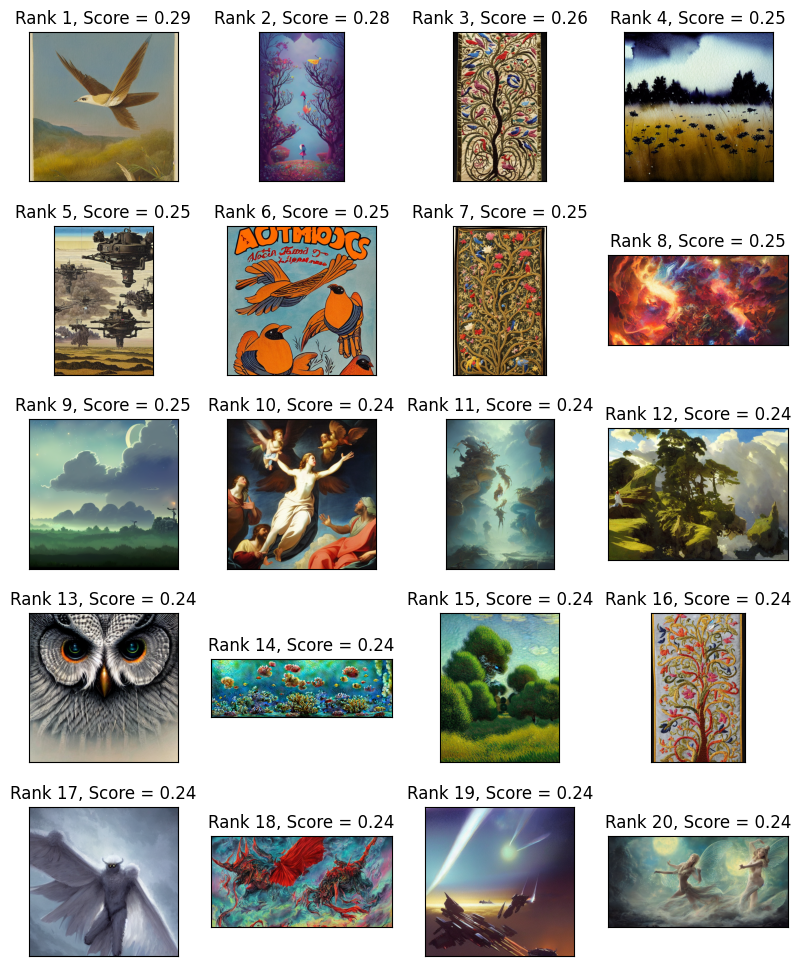

In [21]:
import math

import matplotlib.pyplot as plt

text_query = "Birds in flight"

# Calculate text embedding of query
text_embedding = encode_text_to_embedding(
    model=model, tokenizer=tokenizer, text=[text_query]
)[0]

# Calculate cosine similarity
scores = cosine_similarity(
    text_embedding=text_embedding, image_embeddings=image_embeddings
)

# Set the maximum number of images to display
MAX_IMAGES = 20

# Sort images and scores by descending order of scores and select the top max_images
sorted_data = sorted(
    zip(image_paths_filtered, scores), key=lambda x: x[1], reverse=True
)[:MAX_IMAGES]

# Calculate the number of rows and columns needed to display the images
num_cols = 4
num_rows = math.ceil(len(sorted_data) / num_cols)


# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, (image_path, score) in enumerate(sorted_data):
    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Display the image in the current subplot
    image = copy.deepcopy(Image.open(image_path))
    axs[row_idx, col_idx].imshow(image, cmap="gray")

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Rank {i+1}, Score = {score:.2f}")

    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

Save the dimension size for later usage when creating the index.

In [22]:
DIMENSIONS = len(text_embedding)

DIMENSIONS

512

#### Save the train split in JSONL format.

The data must be formatted in JSONL format, which means each embedding dictionary is written as a JSON string on its own line.

In [ ]:
import tempfile

# Create temporary file to write embeddings to
embeddings_file = tempfile.NamedTemporaryFile(suffix=".json", delete=False)

embeddings_file.name

In [ ]:
import json

BATCH_SIZE = 1000

with open(embeddings_file.name, "a") as f:
    for i in tqdm(range(0, len(image_names), BATCH_SIZE)):
        image_names_chunk = image_names[i : i + BATCH_SIZE]
        image_paths_chunk = image_paths[i : i + BATCH_SIZE]

        embeddings = encode_images_to_embedding_chunked(
            model=model, device=device, image_paths=image_paths_chunk
        )

        # Append to file
        embeddings_formatted = [
            json.dumps(
                {
                    "id": str(id),
                    "embedding": [str(value) for value in embedding],
                }
            )
            + "\n"
            for id, embedding in zip(image_names_chunk, embeddings)
        ]
        f.writelines(embeddings_formatted)

Upload the training data to GCS.

In [ ]:
UNIQUE_FOLDER_NAME = "embeddings_folder_unique"
EMBEDDINGS_INITIAL_URI = f"{BUCKET_URI}/{UNIQUE_FOLDER_NAME}/"
! gsutil cp {embeddings_file.name} {EMBEDDINGS_INITIAL_URI}

## Create Indexes


### Create ANN Index (for Production Usage)

In [26]:
DISPLAY_NAME = "text_to_image"
DESCRIPTION = "CLIP text_to_image embeddings"

Create the ANN index configuration:

To learn more about configuring the index, see [Input data format and structure](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup#input-data-format).


In [27]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [ ]:
tree_ah_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name=DISPLAY_NAME,
    contents_delta_uri=EMBEDDINGS_INITIAL_URI,
    dimensions=DIMENSIONS,
    approximate_neighbors_count=150,
    distance_measure_type="COSINE_DISTANCE",
    leaf_node_embedding_count=500,
    leaf_nodes_to_search_percent=7,
    description=DESCRIPTION,
)

In [ ]:
INDEX_RESOURCE_NAME = tree_ah_index.resource_name
INDEX_RESOURCE_NAME

Using the resource name, you can retrieve an existing MatchingEngineIndex.

In [30]:
tree_ah_index = aiplatform.MatchingEngineIndex(index_name=INDEX_RESOURCE_NAME)

## Create an IndexEndpoint with VPC Network

In [ ]:
# Retrieve the project number
PROJECT_NUMBER = !gcloud projects list --filter="PROJECT_ID:'{PROJECT_ID}'" --format='value(PROJECT_NUMBER)'
PROJECT_NUMBER = PROJECT_NUMBER[0]

VPC_NETWORK = "[YOUR-VPC-NETWORK]"
VPC_NETWORK_FULL = "projects/{}/global/networks/{}".format(PROJECT_NUMBER, VPC_NETWORK)
VPC_NETWORK_FULL

In [ ]:
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=DISPLAY_NAME,
    description=DISPLAY_NAME,
    network=VPC_NETWORK_FULL,
)

## Deploy Indexes

### Deploy ANN Index

In [33]:
DEPLOYED_INDEX_ID = "deployed_index_id_unique"

In [ ]:
my_index_endpoint = my_index_endpoint.deploy_index(
    index=tree_ah_index, deployed_index_id=DEPLOYED_INDEX_ID
)

my_index_endpoint.deployed_indexes

## Create Online Queries

After you built your indexes, you may query against the deployed index to find nearest neighbors.

In [35]:
# Encode query
text_embeddings = encode_text_to_embedding(
    model=model, tokenizer=tokenizer, text=["New York skyline"]
)

In [36]:
# Define number of neighbors to return
NUM_NEIGHBORS = 20

response = my_index_endpoint.match(
    deployed_index_id=DEPLOYED_INDEX_ID,
    queries=text_embeddings,
    num_neighbors=NUM_NEIGHBORS,
)

response

[[MatchNeighbor(id='bdfe4374-fb2e-46a9-bc93-d200f6bb2826.png', distance=0.7390785813331604),
  MatchNeighbor(id='9d990860-cc36-400c-b414-ea7a6257bff8.png', distance=0.73932945728302),
  MatchNeighbor(id='d40a6f34-6300-413f-a9b8-eaa2ca61c065.png', distance=0.7397436499595642),
  MatchNeighbor(id='78f0e041-bf2e-4bb9-bd2e-171f0ccae749.png', distance=0.7446612119674683),
  MatchNeighbor(id='66b428b9-55dc-4907-b116-55aaa887de30.png', distance=0.7514887452125549),
  MatchNeighbor(id='988ae5aa-1e53-4dd3-86e5-1e131f030589.png', distance=0.7520459294319153),
  MatchNeighbor(id='b47e8b3a-cf44-4ad3-b46a-a1ec4eaaf592.png', distance=0.75375896692276),
  MatchNeighbor(id='d937767d-6cd2-4076-a0e4-cf0884b5ccd9.png', distance=0.753847599029541),
  MatchNeighbor(id='4854b74b-372c-4c2d-b83d-0b1d88a57674.png', distance=0.7549178600311279),
  MatchNeighbor(id='8426d51c-41cb-439e-abb4-26dd20998ddb.png', distance=0.7553584575653076),
  MatchNeighbor(id='e7f5f1a7-88d1-4ab3-83b8-f02d50e5d564.png', distance=0.7

Plot the response and verify that images match the text query

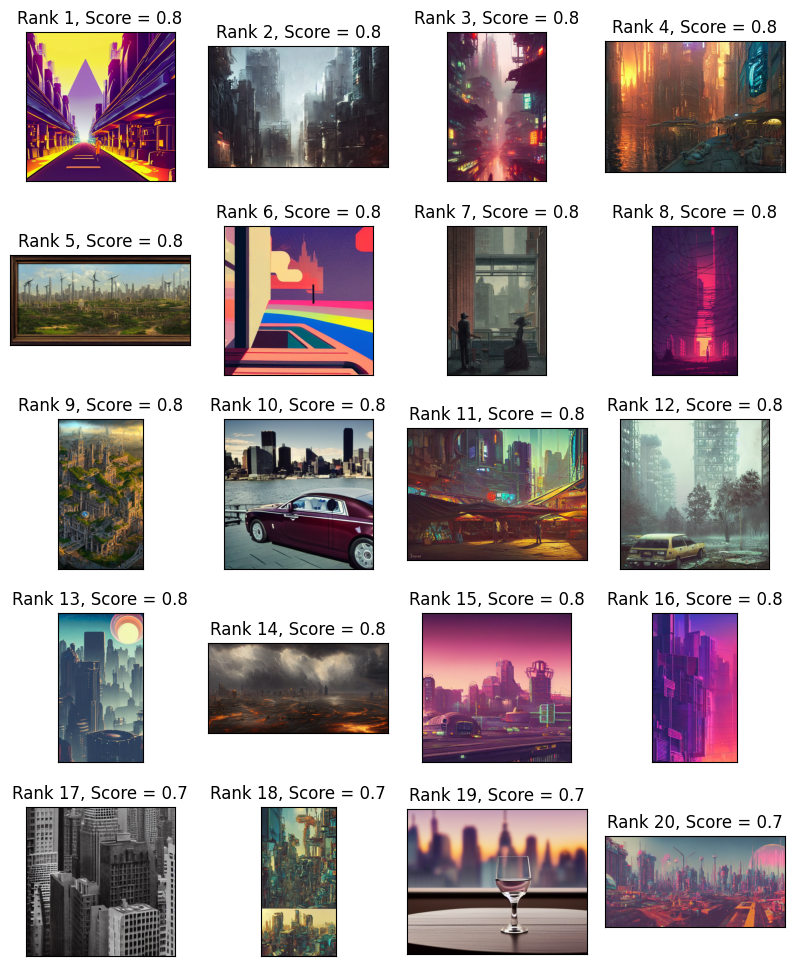

In [37]:
# Sort images and scores by descending order of scores and select the top max_images
sorted_data = sorted(response[0], key=lambda x: x.distance, reverse=True)

# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, response in enumerate(sorted_data):
    image_path = f"{image_directory}/{response.id}"
    score = response.distance

    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Display the image in the current subplot
    if os.path.exists(image_path):
        image = copy.deepcopy(Image.open(image_path))
        axs[row_idx, col_idx].imshow(image, cmap="gray")

        # Set the title of the subplot to the image index and score
        axs[row_idx, col_idx].set_title(f"Rank {i+1}, Score = {score:.2f}")

        # Remove ticks from the subplot
        axs[row_idx, col_idx].set_xticks([])
        axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.
You can also manually delete resources that you created by running the following code.

In [ ]:
# Force undeployment of indexes and delete endpoint
my_index_endpoint.delete(force=True)

In [ ]:
# Delete indexes
tree_ah_index.delete()